In [105]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_curve, auc


# read and look at data
edu = pd.read_csv('https://raw.githubusercontent.com/wchen952/STAT-303-2-Project/main/data/xAPI-Edu-Data.csv')
edu_test = pd.read_csv("https://raw.githubusercontent.com/wchen952/STAT-303-2-Project/main/data/edu_test.csv")

In [106]:
# make train dataset
edu_train = edu.copy()

In [107]:
# clean data 

# get two grades
edu_train = edu_train.loc[edu['GradeID'].isin(['G-07','G-08'])]

# drop stageID, sectionID, semester, relation, parentansweringsurvey, parentschoolsatisfaction
edu_train.drop(['NationalITy', 'PlaceofBirth', 'StageID', 'SectionID', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction'], inplace = True, axis = 1)

#dropping na values
edu_train.dropna(inplace =True)

# drop English topic because there are only two observations 
edu_train = edu_train[edu_train.Topic != 'English']

# drop low
edu_train = edu_train[edu_train.Class != 'L']

#replacing M with 0 and H with 1
edu_train["Class"].replace(to_replace = {'M': 0, 'H': 1}, inplace = True)

In [108]:
edu_train['Topic'].value_counts()

Biology      26
Geology      24
Arabic       22
Spanish      17
Chemistry    16
IT           13
Science      13
Quran        13
History      10
Math          9
Name: Topic, dtype: int64

In [109]:
edu_train['Class'].value_counts()

0    101
1     62
Name: Class, dtype: int64

In [110]:
# developing model
model1 = smf.logit(formula = 'Class~gender+raisedhands+VisITedResources+AnnouncementsView+Discussion+StudentAbsenceDays', data = edu_train).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.442542
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  163
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.3338
Time:                        13:59:20   Log-Likelihood:                -72.134
converged:                       True   LL-Null:                       -108.27
Covariance Type:            nonrobust   LLR p-value:                 1.395e-13
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.8299      1.708     -5.171      0.000     -12.177      -5.483
gender[T.M]                      -1.3045      0.476     -2.740      0.006      -2.238      -0.371
StudentAbsenceDays[T.Under-7]     2.2674      0.796      2.849      0.004       0.707       3.827
raisedhands                       0.0250      0.012      2.158      0.031       0.002       0.048
VisITedResources                  0.0550      0.017      3.148      0.002       0.021       0.089
AnnouncementsView                 0.0014      0.010      0.134      0.893      -0.019       0.021
Discussion                        0.0204      0.008      2.439      0.015       0.004       0.037
=================================================================================================
"""

In [111]:
# predict
pred_class = model1.predict(edu_test)
pred_class

0     0.096737
1     0.155446
2     0.906027
3     0.125585
4     0.358812
5     0.711294
6     0.007423
7     0.004618
8     0.000098
9     0.000461
10    0.729591
11    0.725637
12    0.004811
13    0.003411
14    0.865975
15    0.606794
16    0.012744
17    0.037264
18    0.028499
19    0.039297
20    0.217790
21    0.131981
22    0.937979
23    0.925367
24    0.001899
25    0.002195
26    0.729586
27    0.841498
28    0.322416
29    0.413903
dtype: float64

In [112]:
edu_train.corr()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,Class
raisedhands,1.000000,0.526306,0.534150,0.261052,0.379809
VisITedResources,0.526306,1.000000,0.458145,0.089096,0.400705
AnnouncementsView,0.534150,0.458145,1.000000,0.262746,0.219604
Discussion,0.261052,0.089096,0.262746,1.000000,0.269701
Class,0.379809,0.400705,0.219604,0.269701,1.000000


In [113]:
continuous_vars = edu[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]

continuous_vars.columns[1:]

continuous_vars = add_constant(continuous_vars)
vif_data = pd.DataFrame()
vif_data["feature"] = continuous_vars.columns

for i in range(len(continuous_vars.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(continuous_vars.values, i)

print(vif_data)

             feature       VIF
0              const  5.248221
1        raisedhands  2.317627
2   VisITedResources  2.076660
3  AnnouncementsView  2.003386
4         Discussion  1.228993


In [114]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))


Classification accuracy = 80.0%


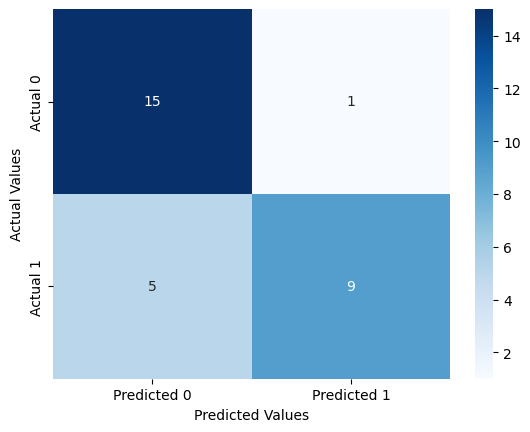

In [115]:
confusion_matrix_test(edu_test,edu_test.Class,model1)


In [116]:
model2 = smf.logit(formula = 'Class ~ gender*Discussion + gender*raisedhands + VisITedResources + AnnouncementsView + StudentAbsenceDays', data = edu_train).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.427232
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  163
Model:                          Logit   Df Residuals:                      154
Method:                           MLE   Df Model:                            8
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.3568
Time:                        13:59:21   Log-Likelihood:                -69.639
converged:                       True   LL-Null:                       -108.27
Covariance Type:            nonrobust   LLR p-value:                 1.733e-13
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.2351      1.920     -4.288      0.000     -11.999      -4.471
gender[T.M]                      -1.5755      1.703     -0.925      0.355      -4.914       1.763
StudentAbsenceDays[T.Under-7]     2.6446      0.855      3.094      0.002       0.969       4.320
Discussion                       -0.0052      0.015     -0.340      0.734      -0.035       0.025
gender[T.M]:Discussion            0.0381      0.019      2.035      0.042       0.001       0.075
raisedhands                       0.0360      0.015      2.383      0.017       0.006       0.066
gender[T.M]:raisedhands          -0.0257      0.022     -1.180      0.238      -0.068       0.017
VisITedResources                  0.0471      0.018      2.672      0.008       0.013       0.082
AnnouncementsView                 0.0065      0.011      0.610      0.542      -0.014       0.028
=================================================================================================
"""

Classification accuracy = 73.3%


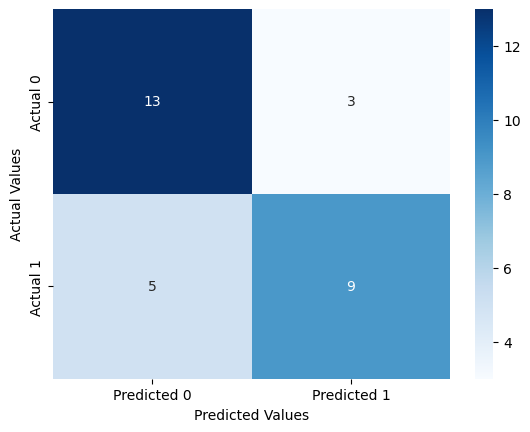

In [117]:
confusion_matrix_test(edu_test,edu_test.Class,model2)



In [118]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))



Classification accuracy = 73.3%
Precision = 68.8%
TPR or Recall = 78.6%
FNR = 21.4%
FPR = 31.2%
ROC-AUC = 82.1%


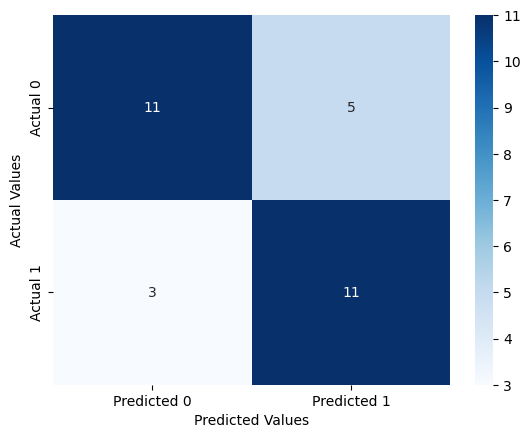

In [131]:
confusion_matrix_data(edu_test,edu_test.Class,model2,0.1)

Classification accuracy = 70.0%
Precision = 64.7%
TPR or Recall = 78.6%
FNR = 21.4%
FPR = 37.5%
ROC-AUC = 82.1%


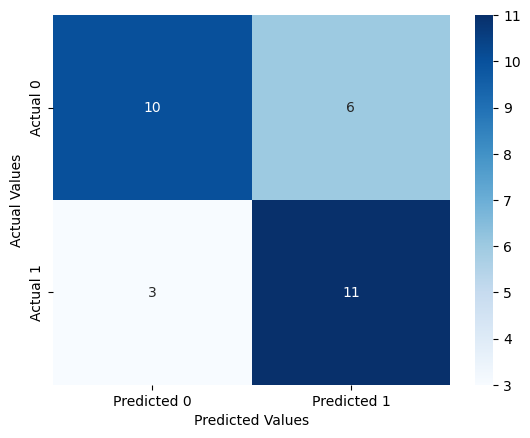

In [134]:
confusion_matrix_data(edu_test,edu_test.Class,model1,0.1)

Classification accuracy = 73.3%
Precision = 68.8%
TPR or Recall = 78.6%
FNR = 21.4%
FPR = 31.2%
ROC-AUC = 82.1%


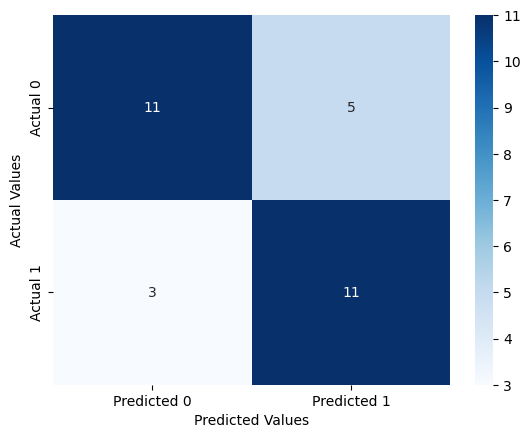

In [135]:
confusion_matrix_data(edu_test,edu_test.Class,model2,0.1)